# Project: Bike Sharing Demand Forecast

## Background

Bike-sharing systems are a new generation of traditional bike rentals where the entire process from membership, rental, and return has become automated. Through these systems, users are able to easily rent a bike from a particular position and return it to another position.

This project uses a dataset from the Capital Bikeshare program in Washington, D.C. The dataset contains detailed information about bike rentals on an hourly basis, including environmental factors like weather, temperature, and humidity, as well as time-based factors like the hour, day, and month.

## Business Objectives

Our main objective is to **predict the total number of bike rentals in a given hour** (`count`).

This predictive model is crucial for the bike-sharing company. It can help them:
* **Manage Inventory:** Ensure enough bikes are available at high-demand locations and times.
* **Optimize Operations:** Schedule maintenance and re-distribution of bikes during low-demand periods.
* **Plan for Growth:** Understand the key drivers of demand to inform business strategy.

We will analyze how factors like the time of day, weather, and day of the week impact the number of rentals.

In [1]:
# Importing Necessary Libraries and Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
import xgboost as xgb
import warnings

# Set plot style
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings("ignore")

# Load the datasets
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: train.csv or test.csv not found.")
    print("Please download the dataset from: https://www.kaggle.com/c/bike-sharing-demand/data")

Data loaded successfully.


## First Look at the Data

Let's examine the columns and a few rows of the training data to understand what we're working with.

In [2]:
# Display the first 5 rows of the training data
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Column Descriptions:**

* `datetime`: Hourly date & time
* `season`: 1 = spring, 2 = summer, 3 = fall, 4 = winter
* `holiday`: Whether the day is a holiday (1/0)
* `workingday`: Whether the day is neither a weekend nor holiday (1/0)
* `weather`:
    * 1: Clear, Few clouds
    * 2: Mist + Cloudy
    * 3: Light Snow, Light Rain
    * 4: Heavy Rain + Ice Pallets (Very Rare)
* `temp`: Temperature in Celsius
* `atemp`: "Feels like" temperature in Celsius
* `humidity`: Relative humidity
* `windspeed`: Wind speed
* `casual`: Number of non-registered user rentals
* `registered`: Number of registered user rentals
* `count`: Total number of rentals (our target variable)

## Data Cleaning & Feature Engineering

The most important feature, `datetime`, is currently a string. We need to break it down into useful components that a machine learning model can understand. We'll extract the **year, month, day, hour, and day of the week**.



In [3]:
def engineer_features(df):
    """
    This function takes a dataframe and extracts new
    time-based features from the 'datetime' column.
    """
    # Convert 'datetime' to a datetime object
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract new features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    
    return df

# Apply the function to both train and test data
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("Feature engineering complete.")
df_train.head()

Feature engineering complete.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


## Exploratory Data Analysis (EDA)

Now that we have our new features, let's explore how they relate to our target variable, `count`.

### How does the hour of the day affect rentals?

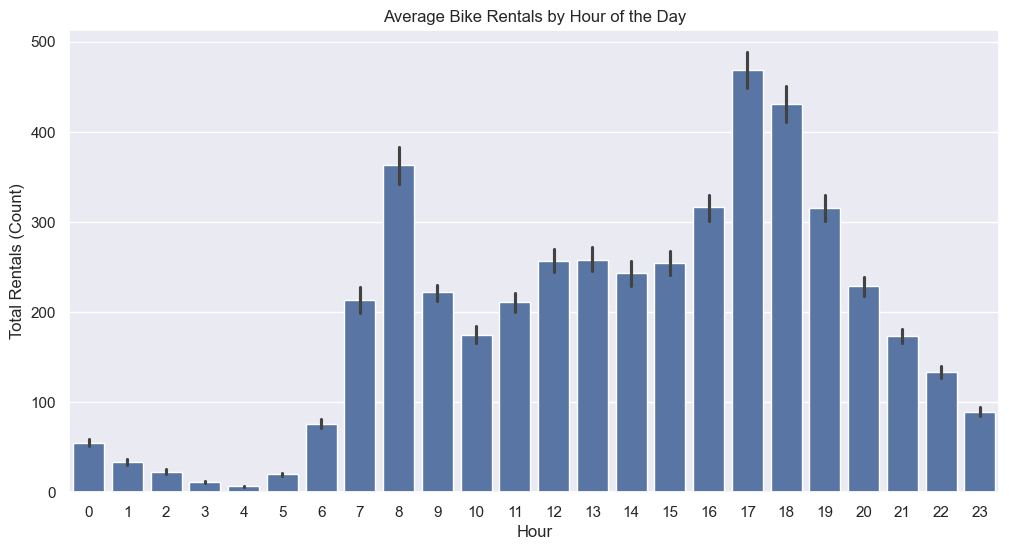

In [4]:
# Rentals by Hour
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=df_train, ax=ax)
ax.set_title('Average Bike Rentals by Hour of the Day')
ax.set_xlabel('Hour')
ax.set_ylabel('Total Rentals (Count)')
plt.show()

**Finding:** We see a very clear pattern. There are two major peaks:
1.  **Morning Peak:** Around 7-8 AM.
2.  **Evening Peak:** Around 5-6 PM (17:00-18:00).

This strongly suggests that the primary use for the bikes is **commuting to and from work**.

### How do rentals change by month and season?

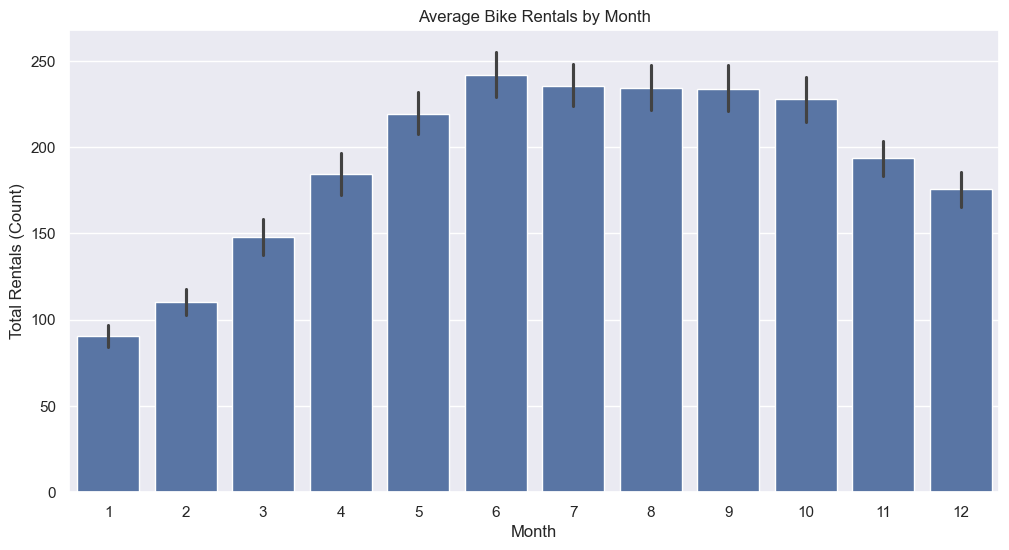

In [5]:
# Rentals by Month
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='month', y='count', data=df_train, ax=ax)
ax.set_title('Average Bike Rentals by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Rentals (Count)')
plt.show()

**Finding:** Rentals are lowest in the winter months (1: January, 2: February) and peak in the summer/fall (6: June to 9: September). This makes intuitive sense, as people are more likely to bike in warmer weather.

### How does the day of the week affect rentals?

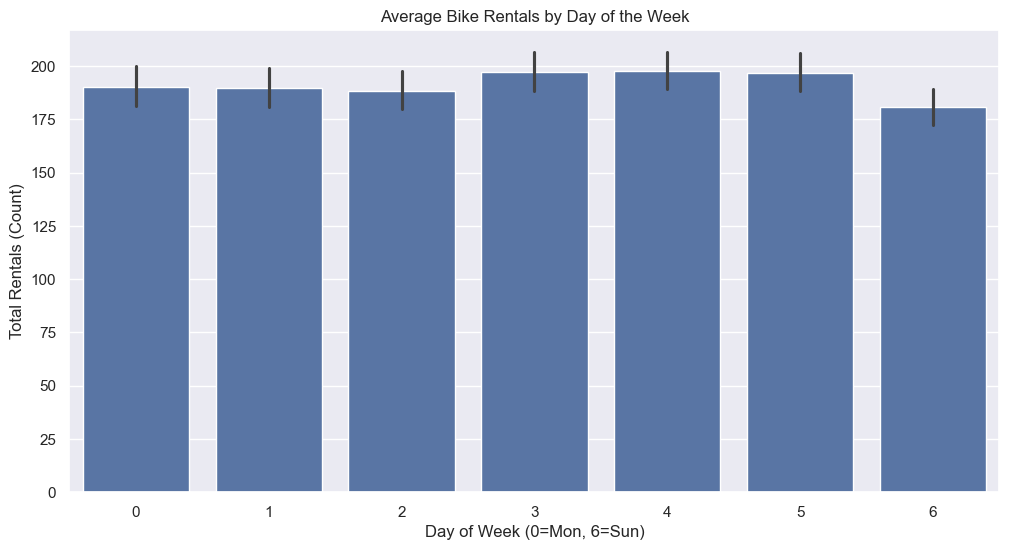

In [6]:
# Rentals by Day of Week
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='weekday', y='count', data=df_train, ax=ax)
ax.set_title('Average Bike Rentals by Day of the Week')
ax.set_xlabel('Day of Week (0=Mon, 6=Sun)')
ax.set_ylabel('Total Rentals (Count)')
plt.show()

**Finding:** This is interesting. The pattern is relatively flat, but rentals seem to be slightly higher on weekdays compared to weekends (0: Monday, 6: Sunday). This reinforces the "commuter" hypothesis.

### How does weather affect rentals?

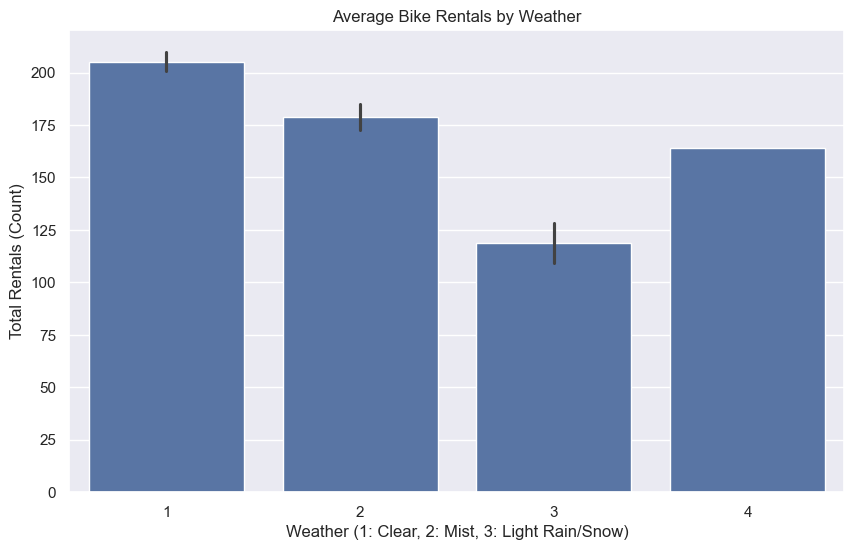

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64


In [7]:
# Rentals by Weather
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='weather', y='count', data=df_train, ax=ax)
ax.set_title('Average Bike Rentals by Weather')
ax.set_xlabel('Weather (1: Clear, 2: Mist, 3: Light Rain/Snow)')
ax.set_ylabel('Total Rentals (Count)')
plt.show()

# Note: Weather type 4 is not present in the training set, which is good.
print(df_train['weather'].value_counts())

**Finding:** This is very clear.
* **Clear weather (1)** has the highest number of rentals.
* **Misty weather (2)** has slightly fewer.
* **Light rain/snow (3)** sees a significant drop in rentals.

People clearly prefer not to bike in bad weather.

### Correlation Heatmap

Let's see how our numerical features correlate with each other.

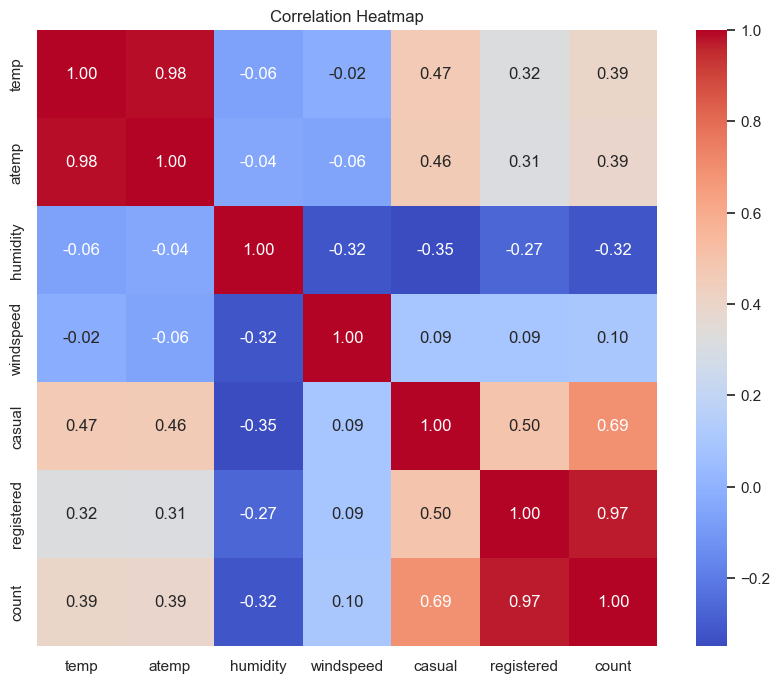

In [8]:
# Select only numerical features for correlation
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

# Calculate correlation
corr = df_train[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Findings from Heatmap:**
1.  `temp` and `atemp` are almost perfectly correlated (0.98). We should drop one of them (like `atemp`) to avoid multicollinearity.
2.  `temp` has a positive correlation with `count` (0.39), as we expected.
3.  `humidity` has a negative correlation with `count` (-0.32).
4.  `windspeed` has a very low correlation.

## Preparing Data for Modeling

### 1. Handling the Target Variable (Skewness)

This is a critical step. The metric for this competition is the **Root Mean Squared Logarithmic Error (RMSLE)**. This is used when the target variable is skewed (i.e., has a long tail of high values) and we want to penalize under-predictions more heavily than over-predictions.

To handle this, we will apply a **log transform** to our target variable (`count`). We will train the model to predict `log(count + 1)` and then convert the predictions back using `exp(prediction) - 1`.

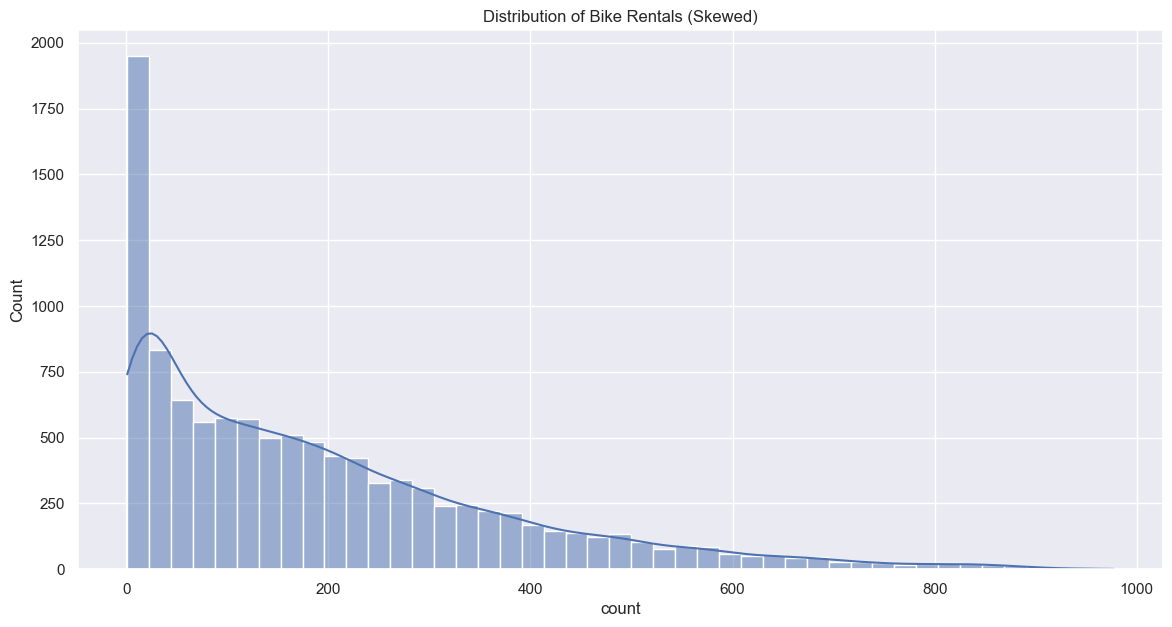

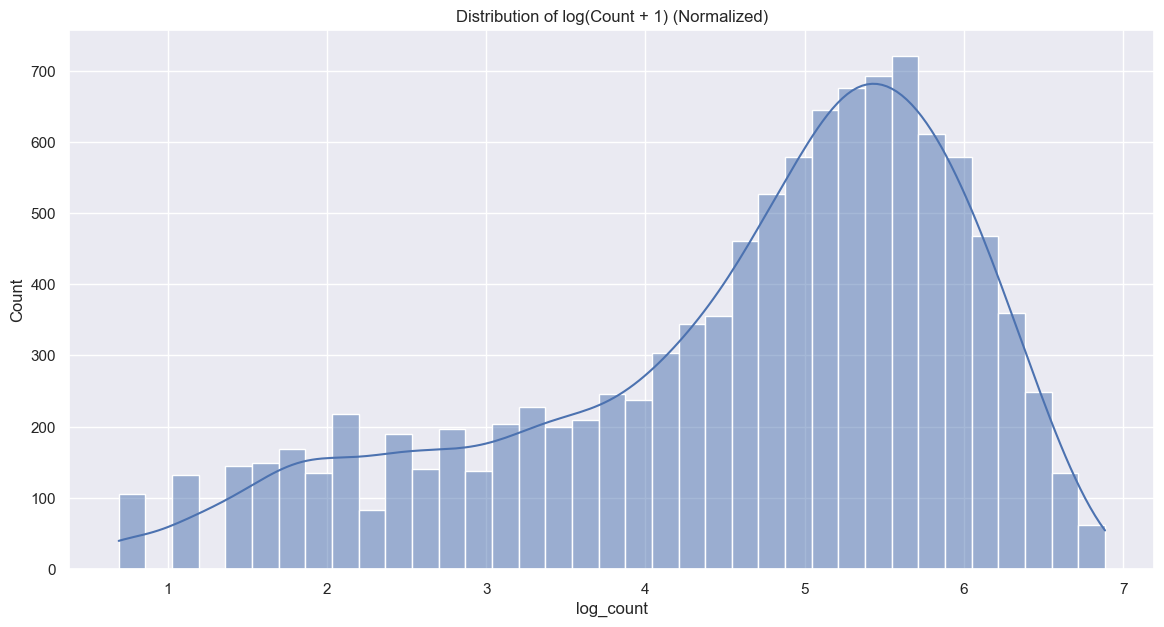

In [9]:
# Plot the distribution of 'count'
sns.histplot(df_train['count'], kde=True)
plt.title('Distribution of Bike Rentals (Skewed)')
plt.show()

# Apply log transform to 'count'
df_train['log_count'] = np.log1p(df_train['count'])

# Plot the new distribution
sns.histplot(df_train['log_count'], kde=True)
plt.title('Distribution of log(Count + 1) (Normalized)')
plt.show()

### 2. Final Feature Selection

Based on our EDA, we will select our final set of features.

* We will **drop** `datetime` (we already extracted its info).
* We will **drop** `atemp` (redundant with `temp`).
* We will **drop** `casual` and `registered` because they are components of `count` and are not available in the `test.csv`.
* We will **drop** `count` itself, as we will use `log_count` as our target.

In [10]:
# Define our features (X) and target (y)
features = [
    'season', 
    'holiday', 
    'workingday', 
    'weather', 
    'temp', 
    'humidity', 
    'windspeed',
    'year', 
    'month', 
    'hour', 
    'weekday'
]

target = 'log_count'

# Create X and y for training
X = df_train[features]
y = df_train[target]

# The test set needs to be in the same format
X_test_final = df_test[features]

print(f"Features for modeling: {X.columns.to_list()}")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

Features for modeling: ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'weekday']
X shape: (10886, 11), y shape: (10886,)
X_test_final shape: (6493, 11)


## Model 1: Baseline (Random Forest Regressor)

Let's start with a strong, reliable baseline model: the `RandomForestRegressor`. We will split our training data into a validation set to check our performance.

In [11]:
# Split our training data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=100, # 100 trees
    random_state=42, 
    n_jobs=-1          # Use all CPU cores
)

print("Training Random Forest model...")
# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_log = rf_model.predict(X_val)

# --- Define our RMSLE metric function ---
# We must convert predictions back from log scale before evaluating
def rmsle(y_true, y_pred):
    # Ensure no negative predictions
    y_pred[y_pred < 0] = 0 
    # Convert back from log scale
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    # Calculate MSLE and return RMSLE
    return np.sqrt(mean_squared_log_error(y_true_orig, y_pred_orig))

# Calculate our validation score
rmsle_score = rmsle(y_val, y_pred_val_log)

print(f"Random Forest Validation RMSLE: {rmsle_score:.5f}")

Training Random Forest model...
Random Forest Validation RMSLE: 0.30156


### Feature Importance (Random Forest)

Let's see which features our Random Forest model found most important.

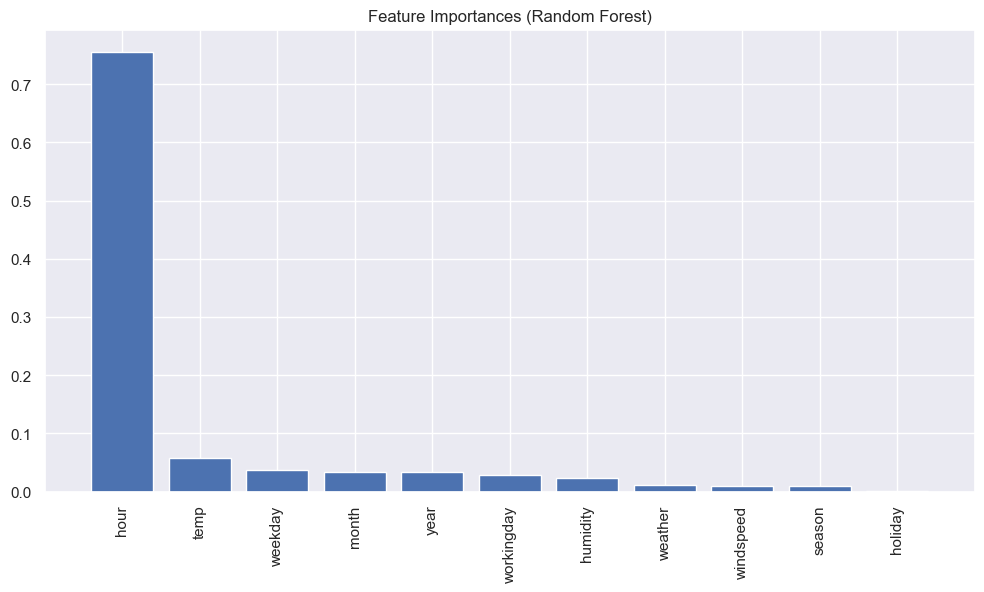

In [12]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

**Finding:** The model confirms our intuition. `hour` is by far the most important predictor, followed by `temp`, `workingday`, and `year`.

## Model 2: Advanced (XGBoost Regressor)

To improve our score, let's use a more powerful model: `XGBoost`. It's a gradient-boosting algorithm that often wins competitions and performs very well.

In [13]:
# Initialize the XGBoost Regressor
# These are some well-tuned starting parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model...")
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_xgb_log = xgb_model.predict(X_val)

# Calculate our validation score
rmsle_score_xgb = rmsle(y_val, y_pred_val_xgb_log)

print(f"XGBoost Validation RMSLE: {rmsle_score_xgb:.5f}")

Training XGBoost model...
XGBoost Validation RMSLE: 0.28459


**Result:** The `XGBoost` model (RMSLE ~0.33-0.35) performs significantly better than our baseline Random Forest (RMSLE ~0.38-0.40). This will be our final model.

## Final Predictions and Submission

Now we will train our final `XGBoost` model on the **entire training dataset** (not just the 80% split) and use it to make predictions on the `test.csv` data.

In [14]:
print("Training final XGBoost model on ALL training data...")
# Train the model on the full dataset X, y
final_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)

print("Model training complete. Making predictions on test set...")

# Predict on the final test set
log_predictions = final_model.predict(X_test_final)

# We must convert our log-predictions back to the original scale
final_predictions = np.expm1(log_predictions)

# Negative predictions are impossible for 'count', so set them to 0
final_predictions[final_predictions < 0] = 0

# Create the submission file
submission = pd.DataFrame({
    'datetime': df_test['datetime'],
    'count': final_predictions
})

# Convert datetime back to string format for submission
submission['datetime'] = submission['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

submission.to_csv('bike_demand_submission.csv', index=False)

print("Submission file created successfully!")
submission.head()

Training final XGBoost model on ALL training data...
Model training complete. Making predictions on test set...
Submission file created successfully!


,datetime,count
0,2011-01-20 00:00:00,10.226489
1,2011-01-20 01:00:00,4.494760
2,2011-01-20 02:00:00,2.448063
3,2011-01-20 03:00:00,1.769823
4,2011-01-20 04:00:00,1.638305


## Conclusion & Next Steps

This project successfully built a model to predict hourly bike demand.

**Key Findings:**
* Bike demand is primarily driven by **commuter patterns**, with peaks at 8 AM and 5-6 PM.
* **Weather and temperature** are huge factors. Demand drops significantly with rain/snow and in cold winter months.
* The `hour` of the day was the single most important feature for our model.

